In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from mpl_toolkits.mplot3d import Axes3D

import re
from collections import OrderedDict
from time import time
import sqlite3       

from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed

In [2]:
# Load data
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-27,5899.740234,5988.390137,5728.819824,5780.899902,5780.899902,1710130048
1,2017-10-28,5787.819824,5876.720215,5689.189941,5753.089844,5753.089844,1403920000
2,2017-10-29,5754.439941,6255.709961,5724.580078,6153.850098,6153.850098,2859040000
3,2017-10-30,6114.850098,6214.990234,6040.850098,6130.529785,6130.529785,1772150016
4,2017-10-31,6132.020020,6470.430176,6103.330078,6468.399902,6468.399902,2311379968


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1.828000e+03
mean,20104.761304,20618.178928,19528.222060,20110.215546,20110.215546,2.585170e+10
std,17080.196202,17520.091188,16565.985064,17072.366582,17072.366582,1.975606e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,1.403920e+09
25%,7529.972168,7697.988159,7390.086426,7539.082641,7539.082641,1.014982e+10
50%,10620.500976,10905.475098,10313.148438,10645.011231,10645.011231,2.359523e+10
75%,33745.441407,34765.743164,32263.608887,33728.771485,33728.771485,3.525977e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [4]:
df.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-27,5899.740234,5988.390137,5728.819824,5780.899902,5780.899902,1710130048
2017-10-28,5787.819824,5876.720215,5689.189941,5753.089844,5753.089844,1403920000
2017-10-29,5754.439941,6255.709961,5724.580078,6153.850098,6153.850098,2859040000
2017-10-30,6114.850098,6214.990234,6040.850098,6130.529785,6130.529785,1772150016
2017-10-31,6132.020020,6470.430176,6103.330078,6468.399902,6468.399902,2311379968
...,...,...,...,...,...,...
2022-10-24,19567.769531,19589.125000,19206.324219,19345.572266,19345.572266,30202235805
2022-10-25,19344.964844,20348.412109,19261.447266,20095.857422,20095.857422,47761524910
2022-10-26,20092.236328,20938.134766,20076.117188,20770.441406,20770.441406,58895950537


In [5]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
df['short_mavg'] = df['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df['long_mavg'] = df['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal
1823,2022-10-24,19567.769531,19589.125000,19206.324219,19345.572266,19345.572266,30202235805,19270.741602,19661.257845,0.0
1824,2022-10-25,19344.964844,20348.412109,19261.447266,20095.857422,20095.857422,47761524910,19373.563867,19658.521810,0.0
1825,2022-10-26,20092.236328,20938.134766,20076.117188,20770.441406,20770.441406,58895950537,19523.798633,19670.666862,0.0
1826,2022-10-27,20772.802734,20854.044922,20255.373047,20285.835938,20285.835938,49625110402,19597.306445,19681.817220,0.0
1827,2022-10-28,20291.861328,20326.228516,20248.439453,20269.542969,20269.542969,50151141376,19690.819141,19681.343034,1.0


In [7]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
df['EMA10'] = EMA(df, 10)
df['EMA30'] = EMA(df, 30)
df['EMA200'] = EMA(df, 200)
df.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
df['ROC10'] = ROC(df['Close'], 10)
df['ROC30'] = ROC(df['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
df['MOM10'] = MOM(df['Close'], 10)
df['MOM30'] = MOM(df['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
df['RSI10'] = RSI(df['Close'], 10)
df['RSI30'] = RSI(df['Close'], 30)
df['RSI200'] = RSI(df['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

df['%K10'] = STOK(df['Close'], df['Low'], df['High'], 10)
df['%D10'] = STOD(df['Close'], df['Low'], df['High'], 10)
df['%K30'] = STOK(df['Close'], df['Low'], df['High'], 30)
df['%D30'] = STOD(df['Close'], df['Low'], df['High'], 30)
df['%K200'] = STOK(df['Close'], df['Low'], df['High'], 200)
df['%D200'] = STOD(df['Close'], df['Low'], df['High'], 200)

In [8]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df['MA10'] = MA(df, 10)
df['MA30'] = MA(df, 30)
df['MA200'] = MA(df, 200)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
1823,2022-10-24,19567.769531,19589.125000,19206.324219,19345.572266,19345.572266,30202235805,19270.741602,19661.257845,0.0,...,46.221382,64.127961,63.975640,49.112543,50.454015,6.249234,6.243674,19270.741602,19367.861068,25303.247295
1824,2022-10-25,19344.964844,20348.412109,19261.447266,20095.857422,20095.857422,47761524910,19373.563867,19658.521810,0.0,...,46.489926,83.989599,73.102752,85.035928,64.621090,9.300518,7.548114,19373.563867,19410.986393,25192.288262
1825,2022-10-26,20092.236328,20938.134766,20076.117188,20770.441406,20770.441406,58895950537,19523.798633,19670.666862,0.0,...,46.730292,92.262083,80.126548,93.595365,75.914612,11.928656,9.159470,19523.798633,19462.578711,25082.229785
1826,2022-10-27,20772.802734,20854.044922,20255.373047,20285.835938,20285.835938,49625110402,19597.306445,19681.817220,0.0,...,46.579229,69.900810,82.050831,75.087052,84.572782,10.233143,10.487439,19597.306445,19501.755013,24972.620606
1827,2022-10-28,20291.861328,20326.228516,20248.439453,20269.542969,20269.542969,50151141376,19690.819141,19681.343034,1.0,...,46.574142,69.148999,77.103964,74.464782,81.049066,10.168450,10.776750,19690.819141,19529.849089,24876.358809


In [9]:

df=df.drop(['High','Low','Open','short_mavg','long_mavg'], axis=1)

In [12]:
df = df.dropna(axis=0)

In [13]:
df.tail()

,Date,Close,Adj Close,Volume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
1823,2022-10-24,19345.572266,19345.572266,30202235805,0.0,19304.311948,19448.087414,25465.126773,1.457640,2.890500,...,46.221382,64.127961,63.975640,49.112543,50.454015,6.249234,6.243674,19270.741602,19367.861068,25303.247295
1824,2022-10-25,20095.857422,20095.857422,47761524910,0.0,19448.229307,19489.879028,25411.701207,4.296033,4.542478,...,46.489926,83.989599,73.102752,85.035928,64.621090,9.300518,7.548114,19373.563867,19410.986393,25192.288262
1825,2022-10-26,20770.441406,20770.441406,58895950537,0.0,19688.631507,19572.495955,25365.519517,6.238549,8.685751,...,46.730292,92.262083,80.126548,93.595365,75.914612,11.928656,9.159470,19523.798633,19462.578711,25082.229785
1826,2022-10-27,20285.835938,20285.835938,49625110402,0.0,19797.214131,19618.517890,25314.975401,4.920862,4.422338,...,46.579229,69.900810,82.050831,75.087052,84.572782,10.233143,10.487439,19597.306445,19501.755013,24972.620606
1827,2022-10-28,20269.542969,20269.542969,50151141376,1.0,19883.092101,19660.519508,25264.772092,5.904050,3.558424,...,46.574142,69.148999,77.103964,74.464782,81.049066,10.168450,10.776750,19690.819141,19529.849089,24876.358809


In [14]:
df = df.drop(columns=['Date'])

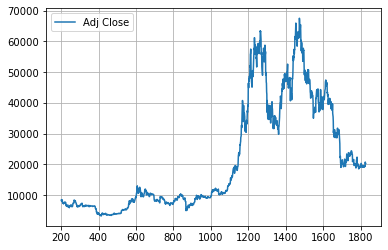

In [15]:
df[['Adj Close']].plot(grid=True)
plt.show()

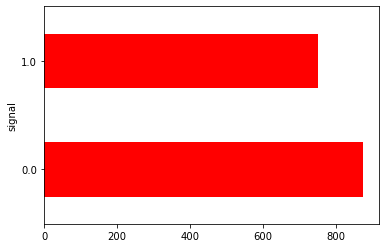

In [16]:
fig = plt.figure()
plot = df.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

In [17]:
# split out validation dataset for the end
validation_df= df.iloc[-10000:]
Y= validation_df["signal"]
X = validation_df.loc[:, df.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
scaled_df = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
scaled_df.dropna(how='any', inplace=True)
scaled_df.head(2)

,Close,Adj Close,Volume,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
1605,1.138455,1.138455,-0.378943,1.112500,1.106178,1.542519,0.478560,-0.042794,0.541723,0.173406,...,-0.479772,0.815966,1.263322,0.431000,0.606544,-0.723276,-0.681412,1.079336,1.070020,1.688320
1022,-0.538451,-0.538451,-0.175779,-0.548397,-0.588414,-0.698548,-0.062131,1.089681,0.168722,0.398887,...,0.532475,0.309018,0.407246,1.207953,1.254880,1.530870,1.541162,-0.541734,-0.598344,-0.706509


Variance preserved by first 5 components == 92.00%


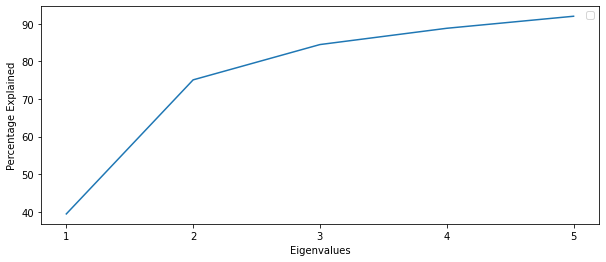

In [19]:
from matplotlib.ticker import MaxNLocator
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(scaled_df)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(scaled_df)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Variance preserved by first 5 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [20]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=scaled_df.index)
print(dfsvd.shape)
dfsvd.head()

(1301, 5)


,c0,c1,c2,c3,c4
1605,2.084833,2.277378,-2.656418,-0.288137,0.207148
1022,1.682554,-2.826386,1.390004,0.290573,0.920144
837,2.080288,-3.506282,-0.469225,0.680750,1.050782
1373,4.769099,-0.082228,-3.515577,-1.106181,-1.015022
1712,-2.964580,2.323156,-1.670060,0.928727,-0.131829


In [21]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

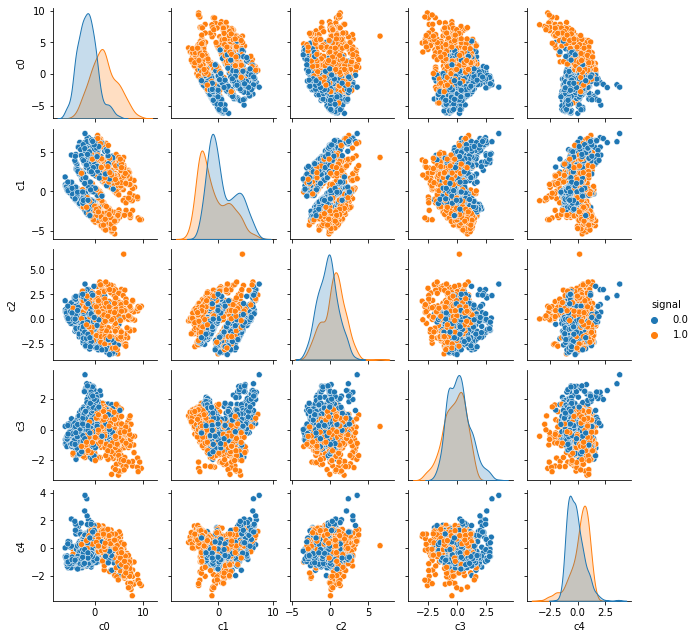

In [22]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['signal']=Y_train
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='signal', size=1.8)

In [23]:
def scatter_3D(A, elevation=30, azimuth=120):
    
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

In [24]:
dfsvd['signal'] = Y_train
interactive(scatter_3D, A=fixed(dfsvd), elevation=30, azimuth=120)

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

In [25]:
tsne = TSNE(n_components=2, random_state=0)

In [26]:
Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

In [27]:
dftsne['signal'] = Y_train

Text(0.5, 1.0, 'Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

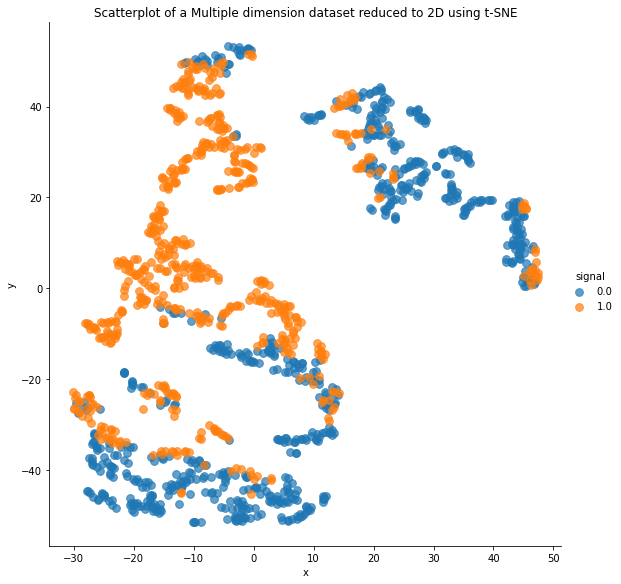

In [28]:
g = sns.lmplot('x', 'y', dftsne, hue='signal', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

In [29]:
# test options for classification
scoring = 'accuracy'

In [30]:
import time
start_time = time.time()

In [31]:
# spot check the algorithms
models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, Y_train, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 3.7641918659210205 seconds ---


In [32]:
start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 1.031404733657837 seconds ---


In [33]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without dimensionality Reduction: 0.940813 (0.008643)
Result with dimensionality Reduction: 0.917760 (0.007076)
